# Variational Auto-Encoder (VAE)

> In this tutorial, we will build a *variational* autoencoder for MNIST.
>
> WIP!

Variational Auto-Encoders (VAE) were introduced in:

> Kingma et al.: *[Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)* (2013) 

- *variational*: Motivation for VAEs was to approximate *Variational Inference* for high-dimensional continuous latent variables
- Variational Inference: Approximation for Bayesian Inference to compute the posterior probability distribution $p(z|x)$ of a latent variable $z$ given an observed variable $x$
- therfore, VAEs are firmly grounded in probability theory
- *Auto-Encoders*: VAEs also compress an input to a latent representation via a Encoder, and try to reconstruct the original input from it with a Decoder

Differences to non-variational Auto-Encoders:

- instead of directly predicting the latent representation and the reconstruction, the encoder and decoder output *parameters for a probability distribution*
- therefore, we need to sample latent representations from the distribution predicted by the encoder, and take the expectation over the decoder output
- VAEs try to produce latent representations $z$, that follow a probability distribution - usually the standard normal distribution $\mathcal{N}(0,1)$
    - this is achieved by including a *Kullback Leibler Divergence* loss term

In [141]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tqdm import tqdm, trange
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision.datasets import MNIST
from torchvision.transforms.v2 import ToTensor, Normalize, Compose, ToImage, ToDtype
from torch.nn.functional import sigmoid
from pyhere import here

np.random.seed(19)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
# load the dataset with help from torchvision

transform = Compose([
    # formerly used ToTensor, which is decaprecated now
    # transforms images to torchvision.tv_tensors_Image
    ToImage(),
    # with scale=True, scales pixel intensities from [0,255] to [0.0,1.0]
    ToDtype(torch.float32, scale=True),
    # could normalize the pixel intensity value to overall mean and std of train set
    # Normalize([0.1307], [0.3081]),
])

data_path = here("data")

artifacts_path = here("artifacts")
models_path = here("artifacts/models/")
models_path.mkdir(parents=True, exist_ok=True)
vae_path = models_path / "vae.pt"

train_ds = MNIST(data_path, train=True, download=True, transform=transform)
test_ds = MNIST(data_path, train=False, download=True, transform=transform)

In [14]:
class Encoder(nn.Module):
    def __init__(self, n_latent=2, *args, **kwargs):
        """Our Encoder: compresses the input image to a low-dimensional representation."""
        super().__init__(*args, **kwargs)
        # how many dimensions our latent space has
        self.n_latent = n_latent
        
        self.conv = nn.Sequential(
            # shape: (N,1,28,28)
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), padding=2),
            # shape: (N,8,28,28)
            nn.MaxPool2d((2,2)),
            # shape: (N,8,14,14)
            # batch norms will help to stabilize and speed up training
            nn.BatchNorm2d(8),
            nn.ReLU(),
            # shape: (N,8,14,14)
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(5,5), padding=2),
            # shape: (N,8,14,14)
            nn.MaxPool2d((2,2)),
            nn.BatchNorm2d(8),
            # shape: (N,8,7,7)
            nn.ReLU(),
            # shape: (N,8,7,7)
            # nn.Flatten(),
        )

        # predicts mean        
        self.linear_mu = nn.Sequential(
            # shape: (N,392)
            nn.Linear(392, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, self.n_latent)
            # no activation function!
        )

        # predicts logarithmic variance
        self.linear_logvar = nn.Sequential(
            # shape: (N,392)
            nn.Linear(392, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, self.n_latent)
            # no activation function here!
        )
 
    def forward(self, x: torch.Tensor):
        x = self.conv(x)
        x = x.flatten(start_dim=1)

        mu = self.linear_mu(x)
        logvar = self.linear_logvar(x)
        return mu, logvar

In [ ]:
class Decoder(nn.Module):
    def __init__(self, n_latent=2, *args, **kwargs):
        """Our Decoder: acts inversely to the encoder and decompresses the latent representation back into an image."""
        super().__init__(*args, **kwargs)
        self.n_latent = n_latent
        self.linear = nn.Sequential(
            nn.Linear(self.n_latent, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 392),
            nn.BatchNorm1d(392),
            nn.ReLU(),
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(8, 8, (5,5), padding=2, stride=2, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            # output_padding does not actually add 0s around the output, just increases the size
            nn.ConvTranspose2d(8, 1, (5,5), padding=2, stride=2, output_padding=1),
            # don't apply sigmoid to return logits
        )
    
    def forward(self, x: torch.Tensor):
        # input shape (N, 10)
        x = self.linear(x)
        # reshape x to the right dimensions
        x = x.unflatten(1, (8,7,7))
        # transposed convolution
        x = self.deconv(x)
        return x

In [5]:
class VAE(nn.Module):
    def __init__(self, encoder_kwargs=None, decoder_kwargs=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        encoder_kwargs = dict() if encoder_kwargs is None else encoder_kwargs
        decoder_kwargs = dict() if decoder_kwargs is None else decoder_kwargs

        self.encoder = Encoder(**encoder_kwargs)
        self.decoder = Decoder(**decoder_kwargs)
    
    def sample(self, mu, logvar):
        # get standard deviation
        sigma = torch.exp(0.5 * logvar)
        # reparameterization trick: neither mu nor sigma is used for sampling
        noise = torch.randn_like(mu)
        z = mu + sigma * noise
        return z

    def forward(self, x, mc_samples: int=1):
        mu, logvar = self.encoder(x) 
        # take expectation over mc_samples latent samples
        zs = [self.sample(mu, logvar) for _ in range(mc_samples)]
        logits = [self.decoder(z) for z in zs]
        zs = torch.stack(zs, dim=1)
        logits = torch.stack(logits, dim=1)
        expect = logits.mean(dim=1)
        # return shape: [batch, sample, channel, height, width]
        return expect, logits, zs, mu, logvar

# Training

- this is the objective function from the paper:

![Equation 10 from Kingma](figures/kingma_eq_10.png)

- $J$ is the number of latent dimensions, $L$ is the number of Monte Carlo samples
- left term: Kullback Leibler Divergence with Standard Normal Distribution
    - for a proof of the Kullback Leibler Divergence for Normal Distributions, see: https://statproofbook.github.io/P/norm-kl.html
    - the parameters $\mu$ and $\sigma$ are produced by our Encoder
    - we will compute the Kullback Leibler Divergence loss term `loss_kld` using the predicted parameters
- right term: ~~reconstruction loss~~ likelihood of observing x given a latent representation z
    - this is implemented by our Decoder - but how?
    - our Decoder produces logits that can be transformed into probabilities $p$ for each pixel
    - we interprete those as parameters for a Bernoulli Distribution for each pixel: how likely is it, that this pixel is "on", given the latent representation?
    - we can use the *Binary Cross Entropy* (BCE) loss for this term (with logits from our decoder)
- important: while the given objective function is *maximized*, we will *minimize* our loss function

In [6]:
from torch.nn import MSELoss
from torch.nn import BCELoss, BCEWithLogitsLoss
from torch.optim import Adam

def train_vae(model: nn.Module, train_dl: DataLoader, n_epochs: int = 5, lr=1e-4, log_interval=10, beta=1, mc_samples=2, device="cpu"):
    model.train()
    model.to(device)
    loss_log = list()

    # criterion_reco = MSELoss()
    criterion_bce = BCEWithLogitsLoss(reduction="sum")
    optimizer = Adam(model.parameters(), lr=lr)

    with tqdm(total=n_epochs * len(train_dl)) as pbar:
        for epoch in range(n_epochs):
            pbar.set_description(f"{epoch}/{n_epochs}")
            for i, (x, _) in enumerate(train_dl):
                optimizer.zero_grad()
                x = x.to(device)
                logits, _, _, mu, logvar = model(x, mc_samples=mc_samples)
                # binary cross entropy as bernoulli likelihood given by decoder params
                loss_bce = criterion_bce(logits, x)
                # the equation below directly results from the KLD between the latent distribution and N(0,1)
                loss_kld = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).sum()
                loss = loss_bce + beta * loss_kld
                loss.backward()
                if i % log_interval == 0:
                    loss_log.append(loss.item())
                optimizer.step()
                pbar.update()
    return loss_log

In [7]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32)

In [8]:
BETA = 1
N_EPOCHS = 10
MC_SAMPLES = 3

In [9]:
model = VAE()

train_loss = train_vae(model, train_dl, n_epochs=N_EPOCHS, beta=BETA, device=device, mc_samples=MC_SAMPLES)

9/10: 100%|██████████| 18750/18750 [02:08<00:00, 146.24it/s]


In [17]:
SAVE_MODEL = True

if SAVE_MODEL:
    torch.save(model.state_dict(), model_path)

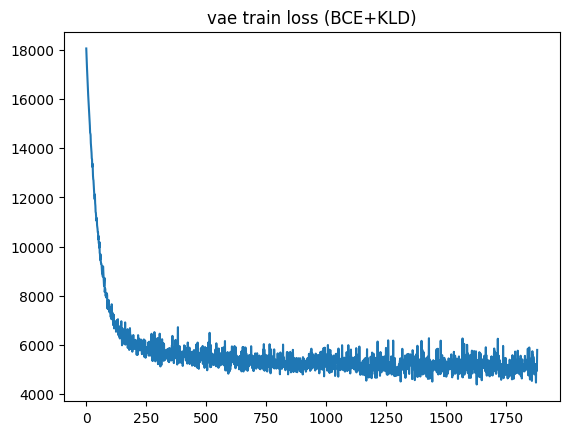

In [18]:
plt.plot(train_loss)
plt.title("vae train loss (BCE+KLD)");

In [89]:
n_test = 1000

x_test = torch.stack([test_ds[i][0] for i in range(n_test)]).to(device)
y_test = torch.tensor([test_ds[i][1] for i in range(n_test)])

In [90]:
model.eval()

with torch.no_grad():
    logits, logits_all, z_test, mu_test, logvar_test = model(x_test, mc_samples = MC_SAMPLES)

In [91]:
x_hat = torch.nn.functional.sigmoid(logits).cpu()

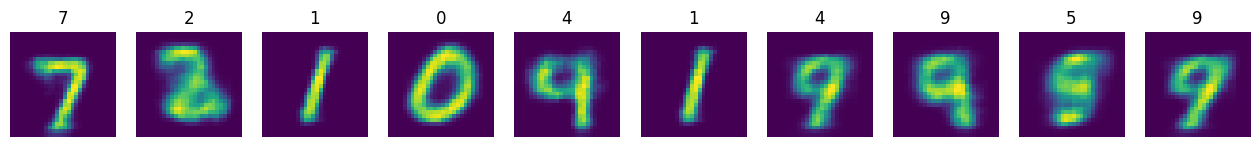

In [92]:
plt.figure(figsize=(16,4))

n_plot = 10
for i, x in enumerate(x_hat[:n_plot]):
    plt.subplot(1, n_plot, i+1)
    plt.imshow(x.squeeze())
    plt.title(y_test[i].item())
    plt.axis(False)

<Axes: xlabel='z_x', ylabel='z_y'>

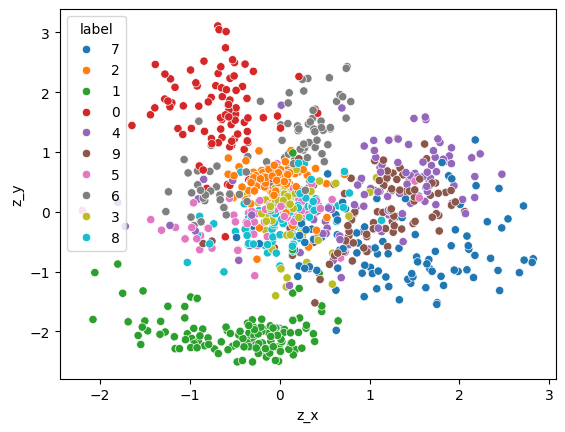

In [93]:
z_xy = z_test.cpu().mean(dim=1)
z_df = pd.DataFrame({
    "z_x": z_xy[:, 0],
    "z_y": z_xy[:, 1],
    "label": y_test.numpy().astype(str)
})

sns.scatterplot(z_df, x="z_x", y="z_y", hue="label")

# Generate new Images!

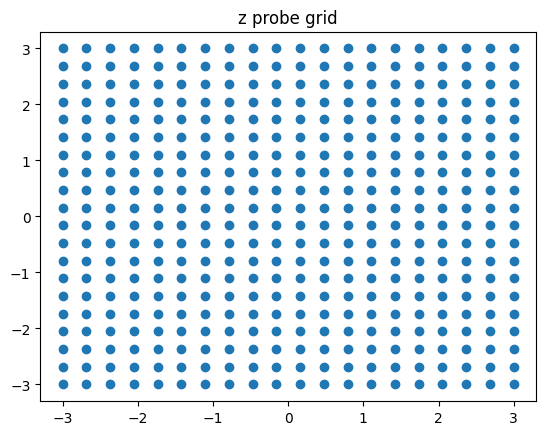

In [138]:
n_gen = 20
xx, yy = np.meshgrid(np.linspace(-3, 3, n_gen), np.linspace(-3, 3, n_gen))
# reverse the order of y coordinates - you will thank me later ;)
yy = yy[::-1]

z_gen = torch.from_numpy(np.stack([xx, yy], axis=2)).reshape(-1, 2).float()
z_gen.shape

plt.scatter(z_gen[:,0], z_gen[:, 1])
plt.title("z probe grid");

In [139]:
with torch.no_grad():
    x_gen = sigmoid(model.decoder(z_gen.to(device)))
    # reshape back into row/column format
    x_gen = x_gen.cpu().reshape(n_gen, n_gen, 1, 28, 28)

x_gen.shape

torch.Size([20, 20, 1, 28, 28])

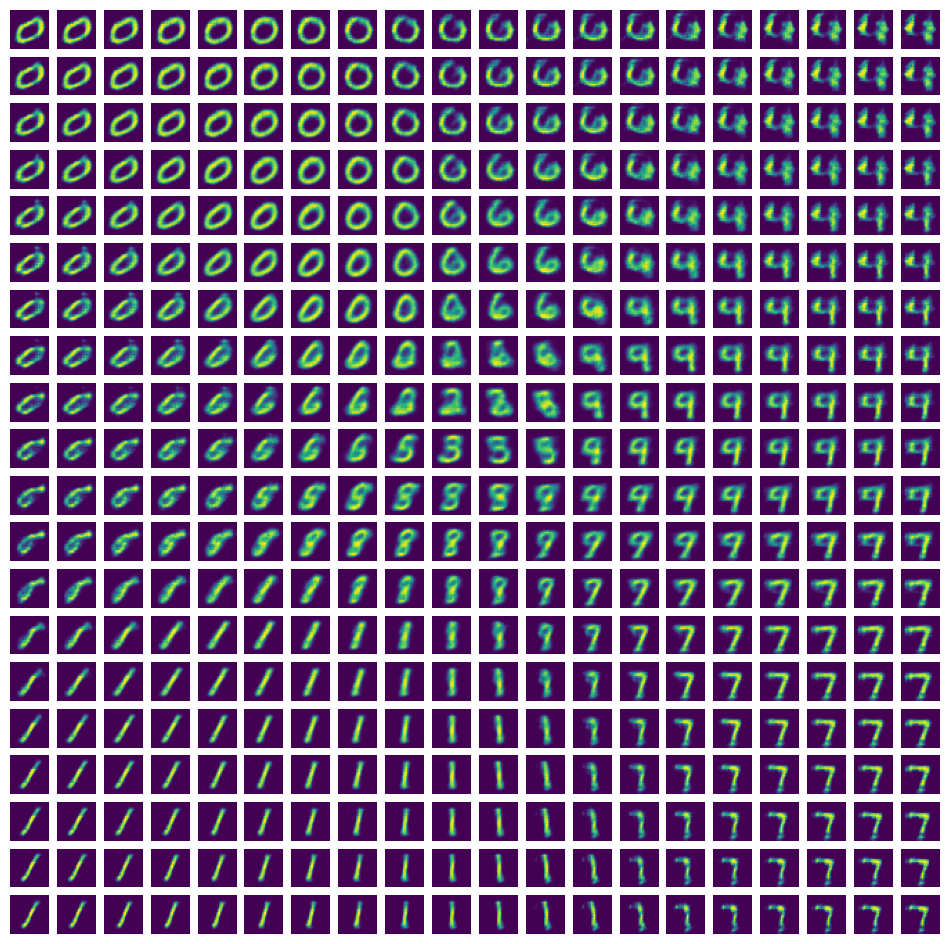

In [140]:
fig, axs = plt.subplots(n_gen, n_gen, figsize=(12,12))

for col in range(n_gen):
    for row in range(n_gen):
        # matplotlib row order starts from the top
        # good thing that we inversed the y coordinate order, right? :D
        axs[row, col].imshow(x_gen[row, col].squeeze())
        axs[row, col].axis(False)

# Bookmarks

- https://lilianweng.github.io/posts/2018-08-12-vae/
    - amazing overview on Autoencoders in general with nice figures
- https://github.com/ludovicobuizza/gan_vae
- 